# Lab Assignment Six: CNNs
### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng
### 1. Preparation
#### 1.1 Metrics


We choose F1-score to evaluate our algorithm's performance. F1-score combines precision and recall into a single metric, providing a balanced assessment of the model's performance. 

In many real-world scenarios, the distribution of classes in the dataset might not be uniform. Accuracy alone can be misleading in such cases. F1-Score, being the harmonic mean of precision and recall, is less affected by class imbalance compared to accuracy. It provides a balanced assessment of the model's performance across different classes.

Depending on the specific application, false positives and false negatives might have different consequences. F1-Score considers both precision and recall, which allows for a balanced evaluation of false positives and false negatives.

F1-Score is easy to interpret and communicate, especially when compared to more complex metrics like AUC-ROC (Area Under the Receiver Operating Characteristic Curve). Its intuitive nature makes it a preferred choice for reporting model performance to stakeholders who might not have a technical background.

Overall, F1-score is well-suited for our car image classification tasks where achieving high precision and recall simultaneously is desirable. By optimizing for F1 score, we ensure a balance between false positives and false negatives, thus enhancing the overall effectiveness and reliability of the model's predictions.

#### 1.2 Dividing Data


We will use stratified 5-Fold Cross-Validation as it ensures that each fold preserves the percentage of samples for each class. This is crucial, especially when dealing with imbalanced datasets where some classes might be significantly underrepresented. By maintaining the class distribution in each fold, we obtain more reliable estimates of model performance across different subsets of data. 

By training the model on multiple different subsets of the data and evaluating its performance on multiple corresponding test sets, Stratified K-Fold Cross-Validation provides a more realistic estimate of how well the model will generalize to unseen data in practice. This mirrors real-world scenarios where the model needs to perform well on diverse data distributions.

stratified K-Fold Cross-Validation in general provides a more robust estimate of model performance compared to a single train-test split. It reduces the risk of overfitting to a particular training set or being overly sensitive to the random assignment of samples to the training and testing sets.

Since the dataset we choosen is computational expansive for our models, we choose 5 folds instead of 10 folds.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

images, labels = [], []
UNIFORMED_SIZE = (64,64)

# load and resize images
for image_path in Path('data').rglob('*.jpg'):
    class_name = image_path.parent.stem
    train_test = image_path.parent.parent.stem
    img = cv2.resize(cv2.imread(str(image_path)), UNIFORMED_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(class_name)

# concatenate to two ndarrays
images_np = np.concatenate([images])
labels_np = np.concatenate([labels])

# scale image to 0-1
images_np = images_np / 255

# encode string lables to numeric labels
encoder = LabelEncoder()
labels_np = encoder.fit_transform(labels_np)
print(f"Images: {images_np.shape}, Labels: {labels_np.shape}")

Images: (4165, 64, 64, 3), Labels: (4165,)


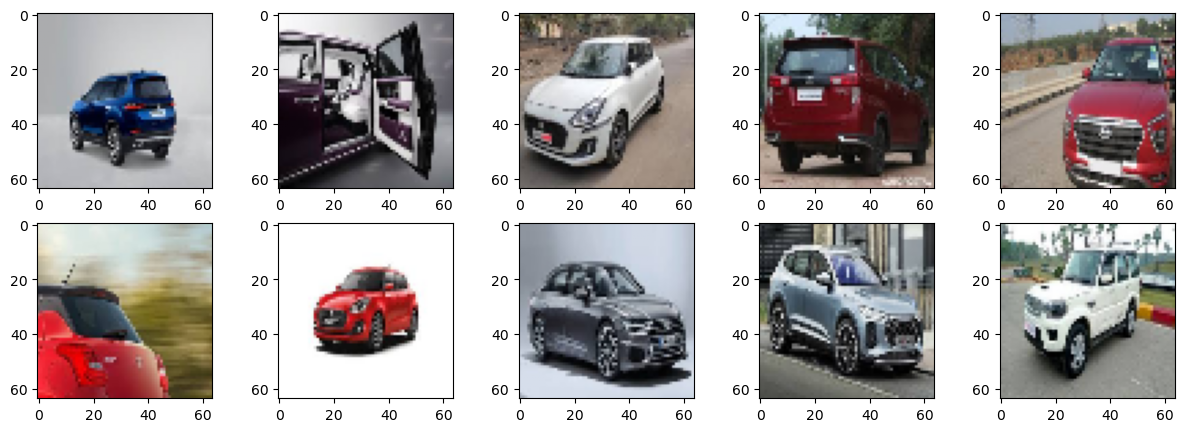

In [2]:
# dataset visualization
plt.figure(figsize=(15, 5))
for i, r_idx in enumerate(np.random.randint(0, images_np.shape[0], 10)):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(images_np[r_idx])

In [3]:
# stratified 5-Fold Cross-Validation
from sklearn.model_selection import StratifiedKFold

n_splits = 5
shuffle_splitter = StratifiedKFold(n_splits=n_splits)

# Iterate over splits
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]
    print(f"Split {fold+1} - Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Split 1 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 2 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 3 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 4 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 5 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)


### 2. Modeling
#### 2.1 Data Expansion (Augmentation)

In [4]:
from keras.utils import to_categorical

num_classes = len(set(y_train))
print("Number of classes:", num_classes)

y_train_ohe = to_categorical(y_train, num_classes=num_classes)

y_test_ohe = to_categorical(y_test, num_classes=num_classes)

print(f"Y train shape: {y_train_ohe.shape}, Y test shape: {y_test_ohe.shape}")

Number of classes: 7
Y train shape: (3332, 7), Y test shape: (833, 7)


The y_train and y_test have been one hot encoded to have 7 classes for multiclassification. 

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score


print(f"system keras Version: {keras.__version__}")

system keras Version: 2.15.0


In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0.2, # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)

datagen.fit(X_train)

The chosen data expansion techniques aptly simulate real-world variations in object orientation, position, perspective, and appearance, bolstering the dataset's resilience and its capacity for generalization. By introducing diverse transformations such as rotation, shifting, shearing, and flipping, the model becomes adept at recognizing objects across a spectrum of conditions. Moreover, the inclusion of a customized preprocessing function further diversifies the dataset by introducing variations in color, noise, and image structure, fostering the model's ability to discern essential features amidst variability.

### 2.2 CNN 

The two CNNs architectures we will utilize are AlexNet and Ensemble Nets. 

#### 2.2.1 AlexNet

In [7]:
# example training code
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model, to_categorical

alexnet = Sequential(name='alexnet')

alexnet.add(Conv2D(filters=32,
                   input_shape = (64,64,3),
                   kernel_size= (3,3),
                   padding='same',
                   activation='relu',
                   data_format='channels_last'))
alexnet.add(BatchNormalization())

alexnet.add(Conv2D(filters=64,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))
alexnet.add(BatchNormalization())

alexnet.add(Conv2D(filters=128,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))
alexnet.add(BatchNormalization())

alexnet.add(Dropout(0.25))
alexnet.add(Flatten())
alexnet.add(Dense(128, activation='relu'))
alexnet.add(Dropout(0.5))
alexnet.add(Dense(num_classes, activation='softmax'))

alexnet.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['F1Score'])

alexnet.summary()

Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                           

In [10]:
history_alexnet = alexnet.fit(X_train, y_train_ohe, 
            batch_size=255, epochs=15,  # more epochs/less batch_size?
            shuffle=True, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

Epoch 1/15
14/14 [==============================] - 24s 2s/step - loss: 1.5607 - f1_score: 0.2633 - val_loss: 2.0818 - val_f1_score: 0.2479
Epoch 2/15
14/14 [==============================] - 23s 2s/step - loss: 1.5651 - f1_score: 0.2694 - val_loss: 1.6360 - val_f1_score: 0.2821
Epoch 3/15
14/14 [==============================] - 23s 2s/step - loss: 1.5414 - f1_score: 0.2823 - val_loss: 1.5113 - val_f1_score: 0.2572
Epoch 4/15
14/14 [==============================] - 23s 2s/step - loss: 1.5236 - f1_score: 0.2789 - val_loss: 1.6400 - val_f1_score: 0.2595
Epoch 5/15
14/14 [==============================] - 23s 2s/step - loss: 1.4777 - f1_score: 0.2949 - val_loss: 1.8090 - val_f1_score: 0.2594
Epoch 6/15
14/14 [==============================] - 23s 2s/step - loss: 1.4770 - f1_score: 0.3039 - val_loss: 1.5852 - val_f1_score: 0.2817
Epoch 7/15
14/14 [==============================] - 24s 2s/step - loss: 1.4279 - f1_score: 0.3209 - val_loss: 1.6787 - val_f1_score: 0.2800


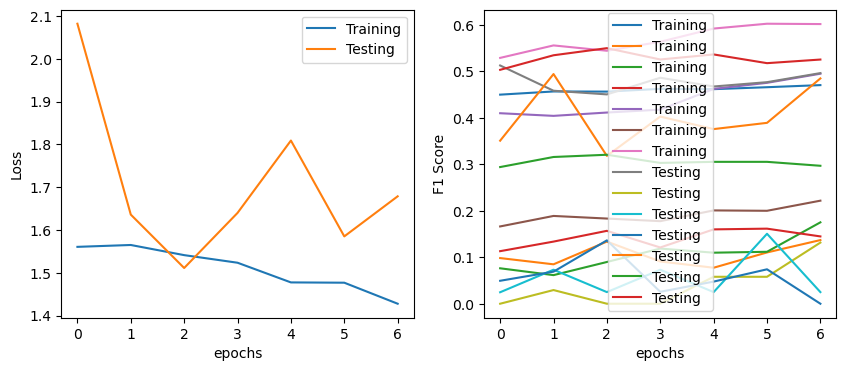

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_alexnet.history['loss'],label='Training')
plt.plot(history_alexnet.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_alexnet.history['f1_score'],label='Training')
plt.plot(history_alexnet.history['val_f1_score'],label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend()

plt.show()

#### 2.2.2 AlexNet with increased number of filters

In [13]:
# example training code
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model, to_categorical

alexnet_1 = Sequential(name='alexnet_modified')

alexnet_1.add(Conv2D(filters=64,
                   input_shape = (64,64,3),
                   kernel_size= (3,3),
                   padding='same',
                   activation='relu',
                   data_format='channels_last'))
alexnet_1.add(BatchNormalization())

alexnet_1.add(Conv2D(filters=128,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))
alexnet_1.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))
alexnet_1.add(BatchNormalization())

alexnet_1.add(Conv2D(filters=256,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))
alexnet_1.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))
alexnet_1.add(BatchNormalization())

alexnet_1.add(Dropout(0.25))
alexnet_1.add(Flatten())
alexnet_1.add(Dense(128, activation='relu'))
alexnet_1.add(Dropout(0.5))
alexnet_1.add(Dense(num_classes, activation='softmax'))

alexnet_1.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['F1Score'])

alexnet_1.summary()

Model: "alexnet_modified"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization_3 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                  

In [14]:
history_alexnet_mod = alexnet.fit(X_train, y_train_ohe, 
            batch_size=255, epochs=15, 
            shuffle=True, verbose=1,
            validation_data=(X_test,y_test_ohe),
             callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

Epoch 1/15
14/14 [==============================] - 24s 2s/step - loss: 1.4261 - f1_score: 0.3146 - val_loss: 1.4751 - val_f1_score: 0.2919
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 1.3900 - f1_score: 0.3576 - val_loss: 1.4559 - val_f1_score: 0.3106
Epoch 3/15
14/14 [==============================] - 24s 2s/step - loss: 1.3483 - f1_score: 0.3746 - val_loss: 1.5135 - val_f1_score: 0.3026
Epoch 4/15
14/14 [==============================] - 24s 2s/step - loss: 1.3710 - f1_score: 0.3493 - val_loss: 1.8087 - val_f1_score: 0.3270
Epoch 5/15
14/14 [==============================] - 24s 2s/step - loss: 1.2977 - f1_score: 0.3765 - val_loss: 1.6302 - val_f1_score: 0.3296
Epoch 6/15
14/14 [==============================] - 24s 2s/step - loss: 1.2917 - f1_score: 0.3870 - val_loss: 1.5773 - val_f1_score: 0.3231


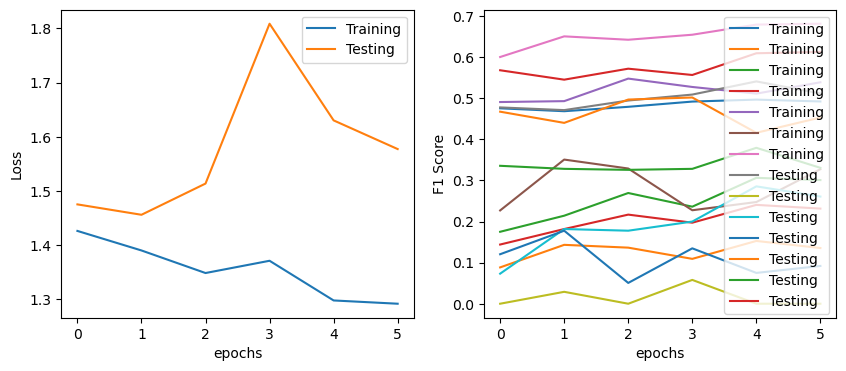

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_alexnet_mod.history['loss'],label='Training')
plt.plot(history_alexnet_mod.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_alexnet_mod.history['f1_score'],label='Training')
plt.plot(history_alexnet_mod.history['val_f1_score'],label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend()

plt.show()

#### 2.2.3 Ensemble Net

In [20]:
from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

num_ensembles = 3
l2_lambda = 0.000001
img_wh = 64

input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(num_classes, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(num_classes, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)

cnn_ens.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['F1Score'])

cnn_ens.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_34 (Conv2D)          (None, 64, 64, 32)           896       ['input_3[0][0]']             
                                                                                                  
 conv2d_35 (Conv2D)          (None, 64, 64, 32)           9248      ['conv2d_34[0][0]']           
                                                                                                  
 max_pooling2d_18 (MaxPooli  (None, 32, 32, 32)           0         ['conv2d_35[0][0]']           
 ng2D)                                                                                      

In [21]:
history_ensnet = cnn_ens.fit(X_train, y_train_ohe, 
            batch_size=255, epochs=15, 
            shuffle=True, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

Epoch 1/15
14/14 [==============================] - 11s 711ms/step - loss: 14.3783 - f1_score: 0.1046 - val_loss: 2.0991 - val_f1_score: 0.0320
Epoch 2/15
14/14 [==============================] - 10s 702ms/step - loss: 1.9290 - f1_score: 0.1085 - val_loss: 1.9019 - val_f1_score: 0.0997
Epoch 3/15
14/14 [==============================] - 10s 717ms/step - loss: 1.8771 - f1_score: 0.1321 - val_loss: 1.8585 - val_f1_score: 0.1363
Epoch 4/15
14/14 [==============================] - 10s 680ms/step - loss: 1.8725 - f1_score: 0.1394 - val_loss: 2.9634 - val_f1_score: 0.0560
Epoch 5/15
14/14 [==============================] - 10s 677ms/step - loss: 2.2788 - f1_score: 0.1302 - val_loss: 1.8861 - val_f1_score: 0.1425
Epoch 6/15
14/14 [==============================] - 9s 673ms/step - loss: 1.8117 - f1_score: 0.1543 - val_loss: 2.0934 - val_f1_score: 0.1046
Epoch 7/15
14/14 [==============================] - 10s 679ms/step - loss: 1.8354 - f1_score: 0.1782 - val_loss: 1.6933 - val_f1_score: 0.2204

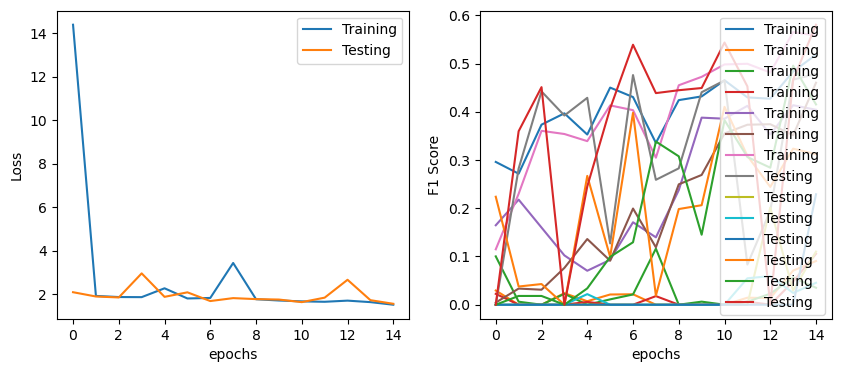

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ensnet.history['loss'],label='Training')
plt.plot(history_ensnet.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ensnet.history['f1_score'],label='Training')
plt.plot(history_ensnet.history['val_f1_score'],label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend()

plt.show()

#### 2.2.4 Ensemble Net with increased filters

In [24]:
num_ensembles = 3
l2_lambda = 0.000001
img_wh = 64

input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=64,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=128,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=128,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(num_classes, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(num_classes, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens_1 = Model(inputs=input_holder,outputs=x)

cnn_ens_1.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['F1Score'])

cnn_ens_1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_62 (Conv2D)          (None, 64, 64, 64)           1792      ['input_5[0][0]']             
                                                                                                  
 conv2d_63 (Conv2D)          (None, 64, 64, 64)           36928     ['conv2d_62[0][0]']           
                                                                                                  
 max_pooling2d_32 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_63[0][0]']           
 ng2D)                                                                                      

In [26]:
history_ensnet_mod = cnn_ens_1.fit(X_train, y_train_ohe, 
            batch_size=255, epochs=15, 
            shuffle=True, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

Epoch 1/15
14/14 [==============================] - 29s 2s/step - loss: 1.9400 - f1_score: 0.0801 - val_loss: 1.9687 - val_f1_score: 0.0537
Epoch 2/15
14/14 [==============================] - 30s 2s/step - loss: 1.9309 - f1_score: 0.0714 - val_loss: 1.9439 - val_f1_score: 0.0572
Epoch 3/15
14/14 [==============================] - 29s 2s/step - loss: 1.9385 - f1_score: 0.0940 - val_loss: 1.9357 - val_f1_score: 0.0537
Epoch 4/15
14/14 [==============================] - 29s 2s/step - loss: 1.9433 - f1_score: 0.0838 - val_loss: 1.9358 - val_f1_score: 0.0537
Epoch 5/15
14/14 [==============================] - 29s 2s/step - loss: 1.9324 - f1_score: 0.1041 - val_loss: 1.9321 - val_f1_score: 0.0537
Epoch 6/15
14/14 [==============================] - 29s 2s/step - loss: 1.9305 - f1_score: 0.0865 - val_loss: 1.9283 - val_f1_score: 0.0560
Epoch 7/15
14/14 [==============================] - 29s 2s/step - loss: 1.9266 - f1_score: 0.0559 - val_loss: 1.9245 - val_f1_score: 0.0560
Epoch 8/15
14/14 [==

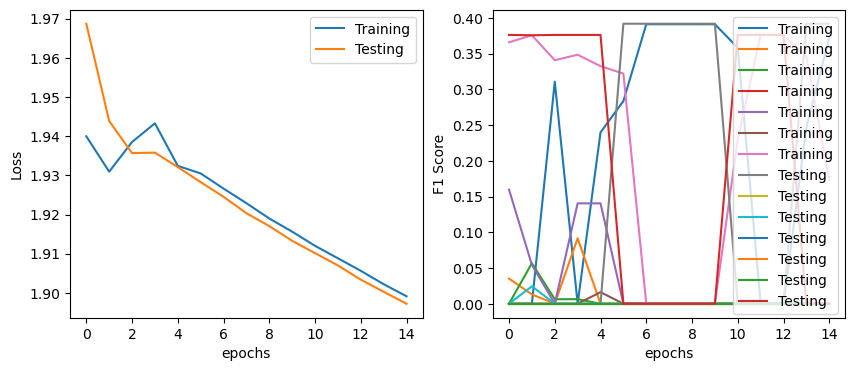

In [27]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ensnet_mod.history['loss'],label='Training')
plt.plot(history_ensnet_mod.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ensnet_mod.history['f1_score'],label='Training')
plt.plot(history_ensnet_mod.history['val_f1_score'],label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend()

plt.show()

References:

- Kaggle. Car Images Dataset.https://www.kaggle.com/datasets/kshitij192/cars-image-datasetresource=download (Accessed 2-14-2024)


- Michael Abebe Berwo, et. al. "Deep Learning Techniques for Vehicle Detection and Classification from Images/Videos: A Survey" Sensors 2023, 23(10), 4832; https://doi.org/10.3390/s23104832


- Sumeyra Tas, et. al. "Deep Learning-Based Vehicle Classification for Low Quality Images" Sensors 2022, 22(13), 4740; https://doi.org/10.3390/s22134740